## What is the true normal human body temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. In 1992, this value was revised to 36.8$^{\circ}$C or 98.2$^{\circ}$F. 

#### Exercise
In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.

Answer the following questions **in this notebook below and submit to your Github account**. 

1.  Is the distribution of body temperatures normal? 
    - Remember that this is a condition for the CLT, and hence the statistical tests we are using, to apply. 
2.  Is the true population mean really 98.6 degrees F?
    - Bring out the one sample hypothesis test! In this situation, is it approriate to apply a z-test or a t-test? How will the result be different?
3.  At what temperature should we consider someone's temperature to be "abnormal"?
    - Start by computing the margin of error and confidence interval.
4.  Is there a significant difference between males and females in normal temperature?
    - Set up and solve for a two sample hypothesis testing.

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

In [13]:
%matplotlib inline

from __future__ import print_function, division

import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
#seaborn settings
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8,4)})

# some nicer colors from http://colorbrewer2.org/
COLOR1 = '#7fc97f'
COLOR2 = '#beaed4'
COLOR3 = '#fdc086'
COLOR4 = '#ffff99'
COLOR5 = '#386cb0'

In [15]:
df = pd.read_csv('data/human_body_temperature.csv')

## Check general info about the data set

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


In [7]:
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [16]:
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


## Is the distribution of body temperatures normal?

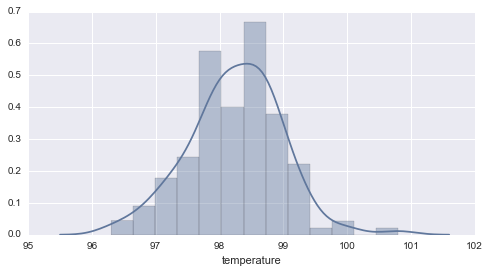

In [16]:
# Use of seaborn
sns.distplot(df.temperature.dropna())

#plt.hist(df.temperature.dropna(), bins=25)

Looks normal but we want to check further with a Q-Q plot.

The package **statsmodels** already has the function **qqplot**.

http://statsmodels.sourceforge.net/devel/generated/statsmodels.graphics.gofplots.qqplot.html

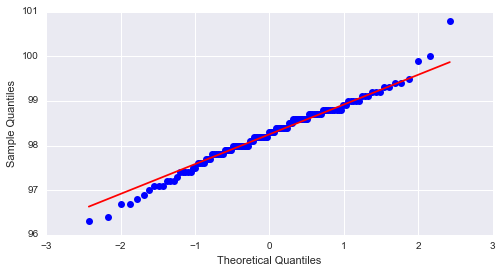

In [32]:
test = np.random.normal(0,1, 1000)
# Available options for the fitting line are '45', 's', 'r', 'q'
sm.qqplot(df.temperature, line='q')
plt.show()

We see an approximately normal distribution although very slightly **left skewed**.

On a second approach we can build a QQ plot ourselves (algorithm taken from *Johnson, Wichern: Applied Multivariate Statistical Analysis*, p.179):

Calculate the **standard normal quantiles**  $q_{(1)},\ldots,q_{(n)}$ 

(using the percent point / inverse cumulative function, an example can be found here https://oneau.wordpress.com/2011/02/28/simple-statistics-with-scipy/#percent-point-function-ppf-or-inverse-cumulative-function) 

and plot the pairs of observations $(x_{(1)},q_{(1)}),\ldots,(x_{(n)},q_{(n)})$ where $x_{(1)},\ldots,x_{(n)}$ are the data points of the temperature sample sorted in increasing order.

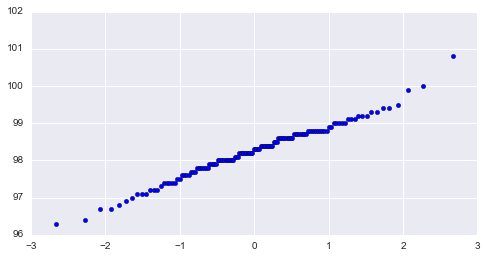

In [68]:
temp_sample_size = len(df.temperature)

# Probability levels (j-0.5)/n for the data points x_j from df.temperature
plevels = np.linspace(1 / temp_sample_size, 1, temp_sample_size) - 0.5 / temp_sample_size

# Standard normal quantiles
# std_norm_quant = np.array([stats.norm.ppf(pl, loc=0.0, scale=1.0) for pl in plevels])

# Same calculation as above only a shorter command
std_norm_quant = stats.norm.ppf(plevels, loc=0.0, scale=1.0)

plt.scatter(std_norm_quant, np.sort(df.temperature))
plt.show()

## Is the true population mean really 98.6 degrees F?

In [35]:
# Check the sample mean
observed_mean = df.temperature.mean()
observed_mean

98.24923076923078

In the following a lot of code reused from Allen Downey's PyCon 2015 lecture (https://youtu.be/5Vjrqnk7Igs)

In [33]:
def summarize_sampling_distribution(sample_stats):
    print('SE', sample_stats.std())
    print('90% CI', np.percentile(sample_stats, [5, 95]))
    print('95% CI', np.percentile(sample_stats, [2.5, 97.5]))
    print('99% CI', np.percentile(sample_stats, [0.5, 99.5]))

In [32]:
class Resampler(object):
    """Represents a framework for computing sampling distributions."""
    
    def __init__(self, sample, xlim=None):
        """Stores the actual sample."""
        self.sample = sample
        self.n = len(sample)
        self.xlim = xlim
        
    def resample(self):
        """Generates a new sample by choosing from the original
        sample with replacement.
        
        New sample will be of the same length due to self.n = len(sample)
        """
        new_sample = np.random.choice(self.sample, self.n, replace=True)
        return new_sample
    
    # the rest is known from previous section
    def sample_stat(self, sample):
        """Computes a sample statistic using the original sample or a
        simulated sample.
        """
        return sample.mean()
    # this ^^ function is called in the loop defined in compute_sample_statistics()
    
    def compute_sample_statistics(self, iters=1000):
        """Simulates many experiments and collects the resulting sample
        statistics.
        """
        stats = [self.sample_stat(self.resample()) for i in range(iters)]
        return np.array(stats)
    
    def plot_sample_stats(self):
        """Runs simulated experiments and summarizes the results.
        """
        sample_stats = self.compute_sample_statistics()
        summarize_sampling_distribution(sample_stats)
        plt.hist(sample_stats, color=COLOR2)
        plt.xlabel('sample statistic')
        plt.xlim(self.xlim)

('SE', 0.062912812234038024)
('90% CI', array([ 98.14538462,  98.35384615]))
('95% CI', array([ 98.12536538,  98.37001923]))
('99% CI', array([ 98.07842692,  98.40386154]))


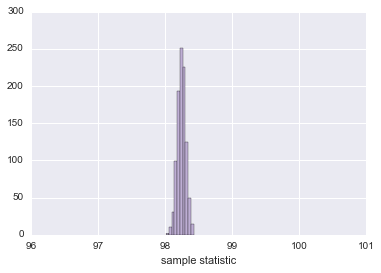

In [817]:
resampler = Resampler(df.temperature, xlim=[96, 101])
resampler.plot_sample_stats()

A look at the calculated confidence intervals already answers the question if 98.6 F is the true mean of the population: with at least a 99% likelyhood it's not since 98.6 lies beyond 98.4054, the right end of the 99% confidence interval.

It's also possible to formally set up the null hypothesis **H0: "98.6 F is the population mean"** and the alternative hypothesis **H1: "it's not"**.

Calculate the p-Value:

In [1139]:
# How often does the test statistic exceed the value that has actually been observed?
#resampler = Resampler(df.temperature, xlim=[96, 101])
test_stats = resampler.compute_sample_statistics(10000)
pvalue = sum(test_stats >= 98.6) / len(test_stats)
pvalue

0.0

The p-Value cannot be observed so we have to reject H0.

## At what temperature should we consider someone's temperature to be "abnormal"?

With a 99% degree of convidence a temperature either below 98.08 F or above 98.04 F is abnormal

## Is there a significant difference between males and females in normal temperature?

In [820]:
temp_males = df.temperature[df.gender == 'M']
temp_females = df.temperature[df.gender == 'F']

We pose the null hypothesis **H0: there is no significant difference in normal temperature of males and females**. That is, the difference of the means should be zero. Below we calculate the standard deviation of the difference of the means of the two samples.

In [1176]:
std_diff_sample_means = (temp_males.std()**2 + temp_females.std()**2)**0.5
t_stat = (temp_males.mean() - temp_females.mean()) / (std_diff_sample_means / 
t_stat

-0.28347326636233994

In [1172]:
n1 = len(temp_males)
n2 = len(temp_females)
std_diff_sample_means = (((n1 - 1) * temp_males.std()**2 + (n2 - 1) * temp_females.std()**2) 
                         / (n1 + n2 - 2))**0.5
std_diff_sample_means

0.7214685210895041

The product of the z-critical value of 1.96 for a two-sided confidence interval with a significance level of 2.5% on each side and the standard deviation calculated above is 

In [1160]:
stats.norm.ppf(0.975) * std_diff_sample_means

1.9997719650516999

The actual difference of the sampled means of the male and female populations is -0.2892

In [1161]:
temp_males.mean() - temp_females.mean()

-0.289230769230727

Since -0.2892 is clearly within the interval [-1.9998, 1.9998], **we cannot reject H0**.

In [1174]:
stats.ttest_ind(temp_males, temp_females, equal_var = False) 

Ttest_indResult(statistic=-2.2854345381656112, pvalue=0.023938264182934196)

## We'll now try to answer the same question withouth using the properties of the normal distribution: Asses the unknown population through Resampling or Permutation.

In [982]:
class HypothesisTest(object):
    """Represents a hypothesis test."""

    def __init__(self, data):
        """Initializes.

        data: data in whatever form is relevant
        """
        self.data = data
        self.MakeModel()
        # test statistic of the real (given) test sample
        self.actual = self.TestStatistic(data)
        self.test_stats = None
        print('init test')

    def PValue(self, iters=1000):
        """Computes the distribution of the test statistic and p-value.

        iters: number of iterations

        returns: float p-value
        
        Array test_stats calculated here also used when MaxTestStat(self) is called
        """
        self.test_stats = np.array([self.TestStatistic(self.RunModel()) 
                                       for _ in range(iters)])

        count = sum(self.test_stats >= self.actual)
        return count / iters

    def MaxTestStat(self):
        """Returns the largest test statistic seen during simulations.
        """
        print('MaxTestStat test')
        return max(self.test_stats)

    def PlotHist(self, label=None):
        """Draws a Cdf with vertical lines at the observed test stat.
        """
        ys, xs, patches = pyplot.hist(ht.test_stats, color=COLOR4)
        pyplot.vlines(self.actual, 0, max(ys), linewidth=3, color='0.8')
        pyplot.xlabel('test statistic')
        pyplot.ylabel('count')

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        raise UnimplementedMethodException()

    def MakeModel(self):
        """Build a model of the null hypothesis.
        """
        pass

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        raise UnimplementedMethodException()



In [987]:
class DiffMeansPermute(HypothesisTest):
    """Tests a difference in means by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        """Build a model of the null hypothesis.
        Called by the constructor of the parent class
        """
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        Called 1000 times by PValue() defined in the parent class
        """
        np.random.shuffle(self.pool)
        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [1104]:
data = (temp_males, temp_females)
ht = DiffMeansPermute(data)
p_value = ht.PValue(iters=1000)
print('\nmeans after permutation')
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

init test

means permute pregnancy length
p-value = 0.0251
actual = 0.289230769231
MaxTestStat test
ts max = 0.544615384615


In [1124]:
class DiffMeansResample(HypothesisTest):
    """Tests a difference in means by resampling."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: data in whatever form is relevant        
        """
        group1, group2 = data
        test_stat = abs(group1.mean() - group2.mean())
        return test_stat

    def MakeModel(self):
        """Build a model of the null hypothesis.
        Called by the constructor of the parent class
        For resampling only the functionality of separating into two groups is needed
        Two groups are needed for TestStatistic(self, data)
        """
        group1, group2 = self.data
        self.n, self.m = len(group1), len(group2)
        self.pool = np.hstack((group1, group2))

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        Called by PValue() defined in the parent class
        """
        #randomized_pool = np.random.choice(self.pool, self.n+self.m, replace=True)
        #self.pool = randomized_pool
        self.pool = np.random.choice(self.pool, self.n+self.m, replace=True)

        data = self.pool[:self.n], self.pool[self.n:]
        return data

In [1162]:
data = (temp_males, temp_females)
ht = DiffMeansResample(data)
p_value = ht.PValue(iters=10000)
print('\nmeans after resampling')
print('p-value =', p_value)
print('actual =', ht.actual)
print('ts max =', ht.MaxTestStat())

init test

means after resampling
p-value = 0.0
actual = 0.289230769231
MaxTestStat test
ts max = 0.275384615385
